In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
  
if IN_COLAB:

    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    sys.path.append('/content/drive/MyDrive/UDA_Sarcasm/models')
    data_path = '/content/drive/MyDrive/UDA_Sarcasm/data/'
    model_path = '/content/drive/MyDrive/UDA_Sarcasm/results/best/'
else:
    import sys
    sys.path.append('../models')
    data_path = '../data/'
    model_path = '../results/best/'

In [2]:
from load_data import load_all_datasets, load_aug_datasets, print_info

# Loading data
ghosh, semeval, political, ptacek, sarc, isarcasm = load_all_datasets(data_path)
all_info = print_info(ghosh, semeval, political, ptacek, sarc, isarcasm)
all_info


/Users/simin/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ghosh,semeval,political,ptacek,sarc,isarcasm
label,,,,,,
0,22725,1923,3260,25756,25000,3584
1,18478,1911,3260,25756,25000,766


In [3]:
from transformers import logging
logging.set_verbosity_error()
import torch
import json
from transformers import BertModel, BertConfig, BertTokenizer
from load_data import multi_dataset, aug_multi_Hidden_dataset
from utils import get_device, get_cfg
from createDataset import HiddenStateDataset
import os
import pandas as pd
import hs_adda
import hidden_trainer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from utils import get_cfg

# get the configuration file
cfg_1 = get_cfg('hs_adda', IN_COLAB= False)

device = get_device()
print('Running on device:', device)

source_name = ['ghosh', 'ptacek']
target_name = ['semeval', 'isarcasm']

# reproduce on test target dataset
semeval_mini = pd.read_csv(data_path + "semeval/semeval_test.tsv", sep= "\t")
isarcasm_mini = pd.read_csv(data_path + "iSarcasm/isarcasm_test.tsv", sep= "\t")

tokenizer_data = BertTokenizer.from_pretrained('bert-base-uncased')
config_data = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
model_data = BertModel.from_pretrained('bert-base-uncased', config = config_data)
model_data = model_data.to(device)

mini_semeval = HiddenStateDataset(semeval_mini, model_data, tokenizer_data, device, 1, max_len = 30)
mini_isarcasm = HiddenStateDataset(isarcasm_mini, model_data, tokenizer_data, device, 1, max_len = 30)

Running on device: mps


# VS. Supervised model on Test data

In [65]:
source = 'ghosh'
target = 'semeval'

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_test/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_test/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, mini_semeval, mini_semeval, mini_semeval, mini_semeval, device, source + '_' + target)
y_pred, y_true = trainer_two.predict()
report = classification_report(y_true.cpu().tolist(), y_pred.cpu().tolist(), output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1']['f1-score'], report['1']['recall'], report['1']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ghosh || Target:  semeval ==================
Class 1: F1:0.6083, Recall0.5789, Precision0.6408
Macro avg: F1:0.6932, Recall0.6900, Precision0.6986


In [36]:
source = 'ghosh'
target = 'isarcasm'

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_test/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_test/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, mini_isarcasm, mini_isarcasm, mini_isarcasm, mini_isarcasm, device, source + '_' + target)
y_pred, y_true = trainer.predict()
report = classification_report(y_true.cpu().tolist(), y_pred.cpu().tolist(), output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1']['f1-score'], report['1']['recall'], report['1']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ghosh || Target:  isarcasm ==================
Class 1: F1:0.4275, Recall0.5600, Precision0.3457
Macro avg: F1:0.6338, Recall0.6740, Precision0.6226


In [43]:
source = 'ptacek'
target = 'semeval'

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_test/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_test/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, mini_semeval, mini_semeval, mini_semeval, mini_semeval, device, source + '_' + target)
y_pred, y_true = trainer.predict()
report = classification_report(y_true.cpu().tolist(), y_pred.cpu().tolist(), output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1']['f1-score'], report['1']['recall'], report['1']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ptacek || Target:  semeval ==================
Class 1: F1:0.6780, Recall0.8000, Precision0.5882
Macro avg: F1:0.6832, Recall0.7000, Precision0.6980


In [56]:
source = 'ptacek'
target = 'isarcasm'

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_test/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_test/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, mini_isarcasm, mini_isarcasm, mini_isarcasm, mini_isarcasm, device, source + '_' + target)
y_pred, y_true = trainer.predict()
report = classification_report(y_true.cpu().tolist(), y_pred.cpu().tolist(), output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1']['f1-score'], report['1']['recall'], report['1']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ptacek || Target:  isarcasm ==================
Class 1: F1:0.4435, Recall0.8226, Precision0.3036
Macro avg: F1:0.5488, Recall0.6655, Precision0.6101


# Equal Layer

In [69]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 1, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 1, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_0()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_0()
        trained_classifier = model_path + '1_equal/'+source+'_'+target+'/classifier.pt'
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '1_equal/'+source+'_'+target+'/target_encoder.pt'
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        y_pred, y_true = trainer_one.predict()
        report = classification_report(y_true.cpu().tolist(), y_pred.cpu().tolist(), output_dict=True)
        print('Class 1: F1:{:.4f}, Recall:{:.4f}, Precision:{:.4f}'.format(report['1']['f1-score'], report['1']['recall'], report['1']['precision']))
        print('Macro avg: F1:{:.4f}, Recall:{:.4f}, Precision:{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ghosh || Target:  semeval ==================
Class 1: F1:0.5000, Recall:0.4126, Precision:0.6344
Macro avg: F1:0.5879, Recall:0.5980, Precision:0.6143
================== Source:  ghosh || Target:  isarcasm ==================
Class 1: F1:0.3143, Recall:0.3438, Precision:0.2895
Macro avg: F1:0.5528, Recall:0.5575, Precision:0.5510
================== Source:  ptacek || Target:  semeval ==================
Class 1: F1:0.5950, Recall:0.5971, Precision:0.5929
Macro avg: F1:0.6215, Recall:0.6215, Precision:0.6214
================== Source:  ptacek || Target:  isarcasm ==================
Class 1: F1:0.1887, Recall:0.1961, Precision:0.1818
Macro avg: F1:0.5073, Recall:0.5077, Precision:0.5072


In [ ]:
import hs_adda
import hidden_trainer

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_0()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_0()
        trained_classifier = model_path + '1_equal/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '1_equal/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

Target: Acc:0.6030, F1:0.5942, Precision:0.6128, recall:0.6030
Target_2: Acc:0.6039, F1:0.5332, Precision:0.6439, recall:0.4554
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/1_equal/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/1_equal/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5738, F1:0.5609, Precision:0.5583, recall:0.5738
Target_2: Acc:0.7140, F1:0.3020, Precision:0.2630, recall:0.3583
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/1_equal/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/1_equal/ptacek_semeval/target_encoder.pt
Target: Acc:0.6646, F1:0.6641, Precision:0.6655, recall:0.6646
Target_2: Acc:0.6650, F1:0.6516, Precision:0.6707, recall:0.6347
================== Source:  ptacek || Target:  isarcasm ==================
load classifier from: ../results/best/1_equal/ptacek_isarcasm/classifier.pt

# Different Layer, Different Classifiers

## Layer 1

In [ ]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 3, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 1, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = model_path + '1_all/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '1_all/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/1_all/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/1_all/ghosh_semeval/target_encoder.pt
Target: Acc:0.6032, F1:0.6029, Precision:0.6035, recall:0.6032
Target_2: Acc:0.6036, F1:0.5944, Precision:0.6044, recall:0.5853
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/1_all/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/1_all/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5850, F1:0.5827, Precision:0.5836, recall:0.5850
Target_2: Acc:0.7531, F1:0.3165, Precision:0.3113, recall:0.3274
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/1_all/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/1_all/ptacek_semeval/target_encoder.pt
Target: Acc:0.6682, F1:0.6646, Precision:0.6742, recall:0.66

## layer 3

In [ ]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 5, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 3, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_3()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_3()
        trained_classifier = model_path + '3_all/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '3_all/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/3_all/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/3_all/ghosh_semeval/target_encoder.pt
Target: Acc:0.5751, F1:0.5337, Precision:0.6126, recall:0.5751
Target_2: Acc:0.5733, F1:0.3990, Precision:0.6800, recall:0.2841
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/3_all/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/3_all/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5508, F1:0.5391, Precision:0.5389, recall:0.5508
Target_2: Acc:0.6931, F1:0.2732, Precision:0.2365, recall:0.3292
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/3_all/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/3_all/ptacek_semeval/target_encoder.pt
Target: Acc:0.6585, F1:0.6548, Precision:0.6652, recall:0.65

## Layer 5

In [ ]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 7, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 5, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_5()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_5()
        trained_classifier = model_path + '5_all/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '5_all/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/5_all/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/5_all/ghosh_semeval/target_encoder.pt
Target: Acc:0.5846, F1:0.5566, Precision:0.6109, recall:0.5846
Target_2: Acc:0.5844, F1:0.4469, Precision:0.6654, recall:0.3373
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/5_all/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/5_all/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5817, F1:0.4704, Precision:0.5484, recall:0.5817
Target_2: Acc:0.5079, F1:0.3306, Precision:0.2175, recall:0.6956
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/5_all/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/5_all/ptacek_semeval/target_encoder.pt
Target: Acc:0.6615, F1:0.6575, Precision:0.6676, recall:0.66

## Layer 7

In [ ]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 9, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 7, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_7()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_7()
        trained_classifier = model_path + '7_all/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '7_all/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/7_all/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/7_all/ghosh_semeval/target_encoder.pt
Target: Acc:0.5832, F1:0.5684, Precision:0.5967, recall:0.5832
Target_2: Acc:0.5842, F1:0.4877, Precision:0.6302, recall:0.3992
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/7_all/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/7_all/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5742, F1:0.5456, Precision:0.5496, recall:0.5742
Target_2: Acc:0.6674, F1:0.3106, Precision:0.2447, recall:0.4294
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/7_all/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/7_all/ptacek_semeval/target_encoder.pt
Target: Acc:0.6447, F1:0.6368, Precision:0.6587, recall:0.64

## Visualization

In [ ]:
my_file = open("../results/text/layer.txt","r").readlines()
layer = ''
# 8 means equal layers
all = {'1':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},'3':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},
       '5':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},'7':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},
       '8':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None} }
name_dic = {0:'ghosh_semeval', 1:'ghosh_isarcasm', 2:'ptacek_semeval', 3:'ptacek_isarcasm'}

result = {}
for i,line in enumerate(my_file):
    if line.startswith("##"):
        layer = line[3:4]
        index = 0
    if line.startswith("================== Source"):
        f1 = my_file[i+3].split(" ")[2][-7:-1]
        precision = my_file[i+3].split(" ")[3][-7:-1]
        recall = my_file[i+3].split(" ")[4][-7:-1]
        result['f1'] = (f1)
        result['precision'] = (precision)
        result['recall'] = (recall)
        name = name_dic[index]
        all[layer][name]= result
        index += 1
        result = {}
results = pd.DataFrame.from_dict({(i,j): all[i][j] 
                                for i in all.keys() 
                                for j in all[i].keys()},
                                orient='index')
results

f1 precision  recall
1 ghosh_semeval    0.6029    0.6035  0.6032
  ghosh_isarcasm   0.5827    0.5836  0.5850
  ptacek_semeval   0.6646    0.6742  0.6682
  ptacek_isarcasm  0.5789    0.5759  0.5859
3 ghosh_semeval    0.5337    0.6126  0.5751
  ghosh_isarcasm   0.5391    0.5389  0.5508
  ptacek_semeval   0.6548    0.6652  0.6585
  ptacek_isarcasm  0.5784    0.5768  0.6089
5 ghosh_semeval    0.5566    0.6109  0.5846
  ghosh_isarcasm   0.4704    0.5484  0.5817
  ptacek_semeval   0.6575    0.6676  0.6615
  ptacek_isarcasm  0.5490    0.5624  0.6003
7 ghosh_semeval    0.5684    0.5967  0.5832
  ghosh_isarcasm   0.5456    0.5496  0.5742
  ptacek_semeval   0.6368    0.6587  0.6447
  ptacek_isarcasm  0.5479    0.5619  0.5992
8 ghosh_semeval    0.5942    0.6128  0.6030
  ghosh_isarcasm   0.5609    0.5583  0.5738
  ptacek_semeval   0.6641    0.6655  0.6646
  ptacek_isarcasm  0.5515    0.5525  0.5527

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


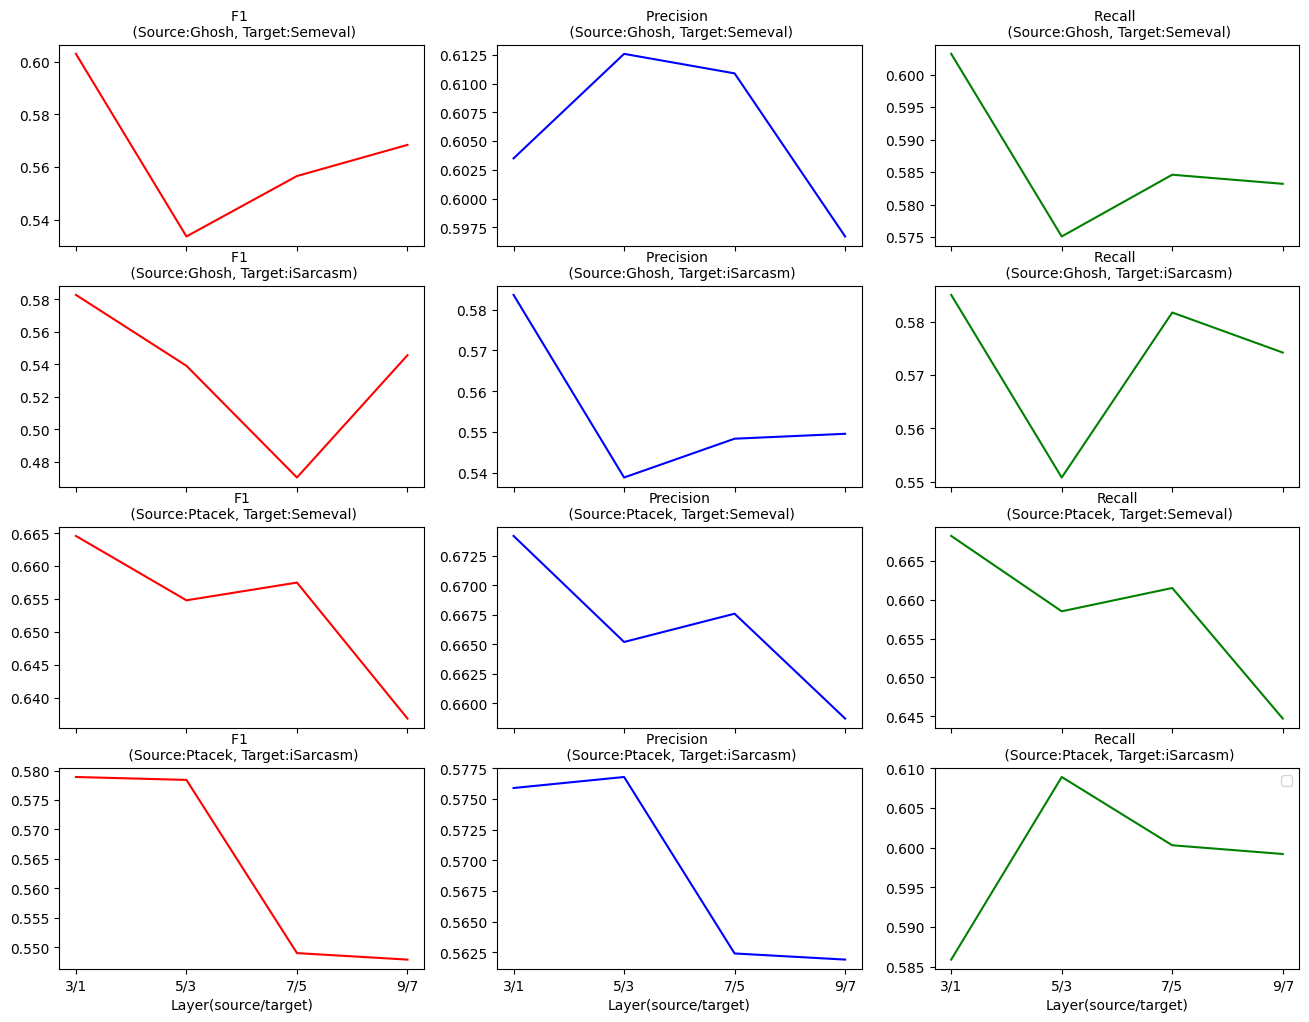

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(16,12), sharex= True)
# fig.suptitle('Change Over Different Layers')
x = ['3/1','5/3','7/5','9/7']
for index in range(0, 4):
    f1=[]
    precision=[]
    recall=[]
    for i in range(0,len(results["f1"].values) -4 ,4):
        f1.append(float(results["f1"].values[i+index]))
        precision.append(float(results["precision"].values[i+index]))
        recall.append(float(results["recall"].values[i+index]))
    axs[index,0].plot(x, f1, color = 'red')
    axs[index,1].plot(x, precision, color = 'blue')
    axs[index,2].plot(x, recall, color = 'green')


axs[0,0].set_title('F1 \n (Source:Ghosh, Target:Semeval)', fontsize=10)
axs[0,1].set_title('Precision \n (Source:Ghosh, Target:Semeval)', fontsize=10)
axs[0,2].set_title('Recall \n (Source:Ghosh, Target:Semeval)', fontsize=10)

axs[1,0].set_title('F1 \n (Source:Ghosh, Target:iSarcasm)', fontsize=10)
axs[1,1].set_title('Precision \n (Source:Ghosh, Target:iSarcasm)', fontsize=10)
axs[1,2].set_title('Recall \n (Source:Ghosh, Target:iSarcasm)', fontsize=10)

axs[2,0].set_title('F1\n (Source:Ptacek, Target:Semeval)', fontsize=10)
axs[2,1].set_title('Precision\n (Source:Ptacek, Target:Semeval)', fontsize=10)
axs[2,2].set_title('Recall\n (Source:Ptacek, Target:Semeval)', fontsize=10)

axs[3,0].set_title('F1 \n (Source:Ptacek, Target:iSarcasm)', fontsize=10)
axs[3,1].set_title('Precision \n (Source:Ptacek, Target:iSarcasm)', fontsize=10)
axs[3,2].set_title('Recall \n (Source:Ptacek, Target:iSarcasm)', fontsize=10)

axs[3,0].set(xlabel='Layer(source/target)')
axs[3,1].set(xlabel='Layer(source/target)')
axs[3,2].set(xlabel='Layer(source/target)')
plt.legend()
plt.show()


# Different Layer, Same Classifier

## 1

In [20]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 3, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 1, max_len = 30, ratio = 1)

for source in source_name:
    for target in target_name:
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = model_path + '1_all/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '1_all/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
        y_pred, y_true = trainer_one.predict()
        report = classification_report(y_true, y_pred, output_dict=True)
        print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
        print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/1_all/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/1_all/ghosh_semeval/target_encoder.pt
Class 1: F1:0.5999, Recall0.5926, Precision0.6074
Macro avg: F1:0.6049, Recall0.6050, Precision0.6051
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/1_all/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/1_all/ghosh_isarcasm/target_encoder.pt
Class 1: F1:0.3246, Recall0.3374, Precision0.3128
Macro avg: F1:0.5869, Recall0.5897, Precision0.5846
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/1_all/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/1_all/ptacek_semeval/target_encoder.pt
Class 1: F1:0.6335, Recall0.5737, Precision0.7073
Macro avg: F1:0.6653, Recall0.6683, Precision0.6745
==========

## 3

In [16]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 5, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 3, max_len = 30, ratio = 1)

for source in source_name:
    for target in target_name:
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = model_path + '3_same/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '3_same/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
        y_pred, y_true = trainer_one.predict()
        report = classification_report(y_true, y_pred, output_dict=True)
        print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
        print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/3_same/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/3_same/ghosh_semeval/target_encoder.pt
Class 1: F1:0.5325, Recall0.4529, Precision0.6460
Macro avg: F1:0.5944, Recall0.6033, Precision0.6136
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/3_same/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/3_same/ghosh_isarcasm/target_encoder.pt
Class 1: F1:0.3124, Recall0.3491, Precision0.2828
Macro avg: F1:0.5717, Recall0.5795, Precision0.5678
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/3_same/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/3_same/ptacek_semeval/target_encoder.pt
Class 1: F1:0.6529, Recall0.6391, Precision0.6673
Macro avg: F1:0.6638, Recall0.6639, Precision0.6643
====

## 5

In [17]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 7, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 5, max_len = 30, ratio = 1)

for source in source_name:
    for target in target_name:
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = model_path + '5_same/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '5_same/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
        y_pred, y_true = trainer_one.predict()
        report = classification_report(y_true, y_pred, output_dict=True)
        print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
        print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))


================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/5_same/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/5_same/ghosh_semeval/target_encoder.pt
Class 1: F1:0.5375, Recall0.4925, Precision0.5916
Macro avg: F1:0.5738, Recall0.5768, Precision0.5791
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/5_same/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/5_same/ghosh_isarcasm/target_encoder.pt
Class 1: F1:0.2657, Recall0.3293, Precision0.2227
Macro avg: F1:0.5307, Recall0.5422, Precision0.5318
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/5_same/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/5_same/ptacek_semeval/target_encoder.pt
Class 1: F1:0.6543, Recall0.6825, Precision0.6284
Macro avg: F1:0.6418, Recall0.6425, Precision0.6434
====

## 7

In [18]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 9, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 7, max_len = 30, ratio = 1)

for source in source_name:
    for target in target_name:
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = model_path + '7_same/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '7_same/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
        y_pred, y_true = trainer_one.predict()
        report = classification_report(y_true, y_pred, output_dict=True)
        print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
        print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))


================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/7_same/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/7_same/ghosh_semeval/target_encoder.pt
Class 1: F1:0.5504, Recall0.5156, Precision0.5903
Macro avg: F1:0.5784, Recall0.5801, Precision0.5814
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/7_same/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/7_same/ghosh_isarcasm/target_encoder.pt
Class 1: F1:0.1813, Recall0.1419, Precision0.2512
Macro avg: F1:0.5252, Recall0.5257, Precision0.5416
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/7_same/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/7_same/ptacek_semeval/target_encoder.pt
Class 1: F1:0.6050, Recall0.5820, Precision0.6298
Macro avg: F1:0.6233, Recall0.6237, Precision0.6246
====

## 9

In [19]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 11, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 9, max_len = 30, ratio = 1)

for source in source_name:
    for target in target_name:
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = model_path + '9_same/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = model_path + '9_same/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
        y_pred, y_true = trainer_one.predict()
        report = classification_report(y_true, y_pred, output_dict=True)
        print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
        print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/9_same/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/9_same/ghosh_semeval/target_encoder.pt
Class 1: F1:0.6237, Recall0.6906, Precision0.5686
Macro avg: F1:0.5802, Recall0.5851, Precision0.5890
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/9_same/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/9_same/ghosh_isarcasm/target_encoder.pt
Class 1: F1:0.2616, Recall0.2877, Precision0.2398
Macro avg: F1:0.5425, Recall0.5468, Precision0.5407
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/9_same/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/9_same/ptacek_semeval/target_encoder.pt
Class 1: F1:0.5189, Recall0.4612, Precision0.5931
Macro avg: F1:0.5691, Recall0.5743, Precision0.5784
====

In [24]:
my_file = open("../results/text/layer_same.txt","r").readlines()
layer = ''
# 8 means equal layers
all = {'1':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},'3':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},
       '5':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},'7':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},
       '9':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None} }
name_dic = {0:'ghosh_semeval', 1:'ghosh_isarcasm', 2:'ptacek_semeval', 3:'ptacek_isarcasm'}

result = {}
for i,line in enumerate(my_file):
    if line.startswith("##"):
        layer = line[3:4]
        index = 0
    if line.startswith("================== Source"):
        f1 = my_file[i+4].split(" ")[2][-7:-1]
        precision = my_file[i+4].split(" ")[3][-7:-1]
        recall = my_file[i+4].split(" ")[4][-7:-1]
        result['f1'] = (f1)
        result['precision'] = (precision)
        result['recall'] = (recall)
        name = name_dic[index]
        all[layer][name]= result
        index += 1
        result = {}
results = pd.DataFrame.from_dict({(i,j): all[i][j] 
                                for i in all.keys() 
                                for j in all[i].keys()},
                                orient='index')
results

f1 precision  recall
1 ghosh_semeval    0.6049    0.6050  0.6051
  ghosh_isarcasm   0.5869    0.5897  0.5846
  ptacek_semeval   0.6653    0.6683  0.6745
  ptacek_isarcasm  0.5793    0.5848  0.5757
3 ghosh_semeval    0.5944    0.6033  0.6136
  ghosh_isarcasm   0.5717    0.5795  0.5678
  ptacek_semeval   0.6638    0.6639  0.6643
  ptacek_isarcasm  0.5985    0.6034  0.5948
5 ghosh_semeval    0.5738    0.5768  0.5791
  ghosh_isarcasm   0.5307    0.5422  0.5318
  ptacek_semeval   0.6418    0.6425  0.6434
  ptacek_isarcasm  0.5335    0.5463  0.5345
7 ghosh_semeval    0.5784    0.5801  0.5814
  ghosh_isarcasm   0.5252    0.5257  0.5416
  ptacek_semeval   0.6233    0.6237  0.6246
  ptacek_isarcasm  0.5404    0.5393  0.5419
9 ghosh_semeval    0.5802    0.5851  0.5890
  ghosh_isarcasm   0.5425    0.5468  0.5407
  ptacek_semeval   0.5691    0.5743  0.5784
  ptacek_isarcasm  0.5425    0.5400  0.5484

In [26]:
results["f1"].values

array(['0.6049', '0.5869', '0.6653', '0.5793', '0.5944', '0.5717',
       '0.6638', '0.5985', '0.5738', '0.5307', '0.6418', '0.5335',
       '0.5784', '0.5252', '0.6233', '0.5404', '0.5802', '0.5425',
       '0.5691', '0.5425'], dtype=object)

In [28]:
for i in range(0,len(results["f1"].values) -4 ,4):
    print(i)

0
4
8
12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


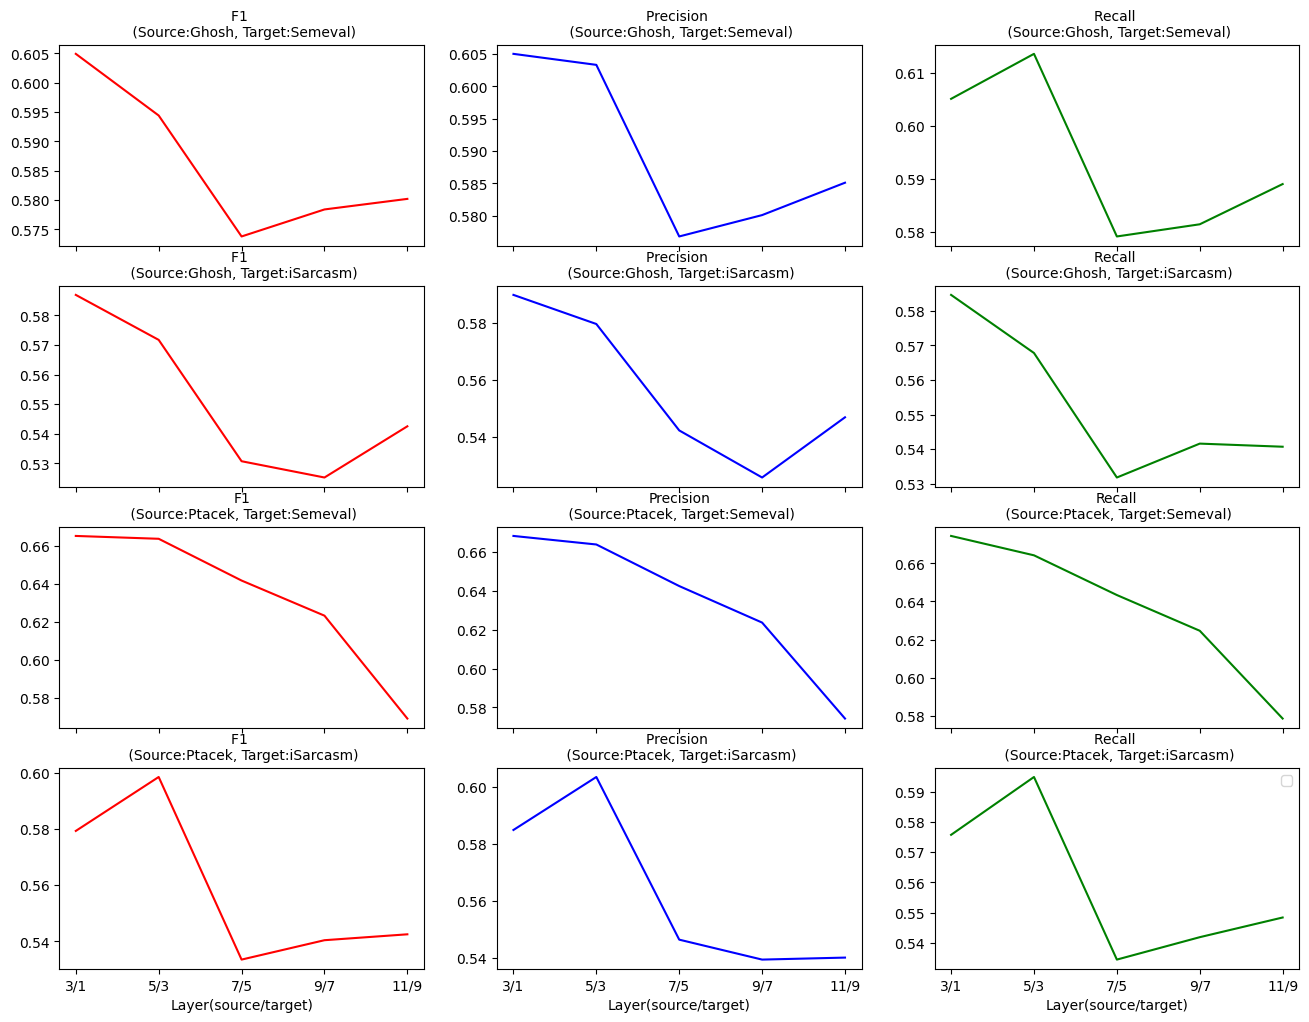

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(16,12), sharex= True)
# fig.suptitle('Change Over Different Layers')
x = ['3/1','5/3','7/5','9/7','11/9']
for index in range(0, 4):
    f1=[]
    precision=[]
    recall=[]
    for i in range(0,len(results["f1"].values) -3, 4):
        f1.append(float(results["f1"].values[i+index]))
        precision.append(float(results["precision"].values[i+index]))
        recall.append(float(results["recall"].values[i+index]))
    axs[index,0].plot(x, f1, color = 'red')
    axs[index,1].plot(x, precision, color = 'blue')
    axs[index,2].plot(x, recall, color = 'green')


axs[0,0].set_title('F1 \n (Source:Ghosh, Target:Semeval)', fontsize=10)
axs[0,1].set_title('Precision \n (Source:Ghosh, Target:Semeval)', fontsize=10)
axs[0,2].set_title('Recall \n (Source:Ghosh, Target:Semeval)', fontsize=10)

axs[1,0].set_title('F1 \n (Source:Ghosh, Target:iSarcasm)', fontsize=10)
axs[1,1].set_title('Precision \n (Source:Ghosh, Target:iSarcasm)', fontsize=10)
axs[1,2].set_title('Recall \n (Source:Ghosh, Target:iSarcasm)', fontsize=10)

axs[2,0].set_title('F1\n (Source:Ptacek, Target:Semeval)', fontsize=10)
axs[2,1].set_title('Precision\n (Source:Ptacek, Target:Semeval)', fontsize=10)
axs[2,2].set_title('Recall\n (Source:Ptacek, Target:Semeval)', fontsize=10)

axs[3,0].set_title('F1 \n (Source:Ptacek, Target:iSarcasm)', fontsize=10)
axs[3,1].set_title('Precision \n (Source:Ptacek, Target:iSarcasm)', fontsize=10)
axs[3,2].set_title('Recall \n (Source:Ptacek, Target:iSarcasm)', fontsize=10)

axs[3,0].set(xlabel='Layer(source/target)')
axs[3,1].set(xlabel='Layer(source/target)')
axs[3,2].set(xlabel='Layer(source/target)')
plt.legend()
plt.show()


# Different augmentation techniques

In [ ]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 3, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 1, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = '../results/best/noaug/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = '../results/best/noaug/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/noaug/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/noaug/ghosh_semeval/target_encoder.pt
Target: Acc:0.5962, F1:0.5946, Precision:0.5976, recall:0.5962
Target_2: Acc:0.5967, F1:0.5727, Precision:0.6082, recall:0.5422
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/noaug/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/noaug/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5923, F1:0.5895, Precision:0.5888, recall:0.5923
Target_2: Acc:0.7590, F1:0.3261, Precision:0.3211, recall:0.3351
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/noaug/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/noaug/ptacek_semeval/target_encoder.pt
Target: Acc:0.6707, F1:0.6699, Precision:0.6707, recall:0.67

In [ ]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 3, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 1, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = '../results/best/repeat_noaug/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = '../results/best/repeat_noaug/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/repeat_noaug/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/repeat_noaug/ghosh_semeval/target_encoder.pt
Target: Acc:0.6096, F1:0.5890, Precision:0.6376, recall:0.6096
Target_2: Acc:0.6106, F1:0.4970, Precision:0.6986, recall:0.3865
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/repeat_noaug/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/repeat_noaug/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5932, F1:0.5863, Precision:0.5843, recall:0.5932
Target_2: Acc:0.7462, F1:0.3294, Precision:0.3098, recall:0.3575
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/repeat_noaug/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/repeat_noaug/ptacek_semeval/target_encoder.pt
Target: Acc:0.6643

In [ ]:
import hs_adda
import hidden_trainer

source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 3, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 1, max_len = 30, ratio = 1)

for source in source_name:
    src_train = source_dic[source + '_train']
    src_val = source_dic[source + '_val']
    for target in target_name:
        tgt_train = target_dic[target + '_train']
        tgt_val = target_dic[target + '_val']
        print('================== Source: ', source, '|| Target: ', target,'==================')
        tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
        discriminator = hs_adda.HS_ADDN_Discriminator_0()
        src_classifier = hs_adda.HS_ADDN_Classifier_1()
        trained_classifier = '../results/best/repeat_aug/'+source+'_'+target+'/classifier.pt'
        print('load classifier from:', trained_classifier)
        src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
        trained_encoder = '../results/best/repeat_aug/'+source+'_'+target+'/target_encoder.pt'
        print('load trained_encoder from:', trained_encoder)
        tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
        trainer_one = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, src_train, src_val, tgt_train, tgt_val, device, source + '_' + target)
        trainer_one.eval_model()

================== Source:  ghosh || Target:  semeval ==================
load classifier from: ../results/best/repeat_aug/ghosh_semeval/classifier.pt
load trained_encoder from: ../results/best/repeat_aug/ghosh_semeval/target_encoder.pt
Target: Acc:0.5988, F1:0.5863, Precision:0.6123, recall:0.5988
Target_2: Acc:0.5992, F1:0.5145, Precision:0.6500, recall:0.4265
================== Source:  ghosh || Target:  isarcasm ==================
load classifier from: ../results/best/repeat_aug/ghosh_isarcasm/classifier.pt
load trained_encoder from: ../results/best/repeat_aug/ghosh_isarcasm/target_encoder.pt
Target: Acc:0.5950, F1:0.5817, Precision:0.5776, recall:0.5950
Target_2: Acc:0.7279, F1:0.3346, Precision:0.2960, recall:0.3891
================== Source:  ptacek || Target:  semeval ==================
load classifier from: ../results/best/repeat_aug/ptacek_semeval/classifier.pt
load trained_encoder from: ../results/best/repeat_aug/ptacek_semeval/target_encoder.pt
Target: Acc:0.6651, F1:0.6596,

In [ ]:
my_file = open("../results/text/aug.txt","r").readlines()
layer = ''
all = {'No_augment':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},'Augment':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},
       'Repeat_No_augment':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None},'Repeat_augment':{'ghosh_semeval':None, 'ghosh_isarcasm':None, 'ptacek_semeval':None, 'ptacek_isarcasm':None}}
name_dic = {0:'ghosh_semeval', 1:'ghosh_isarcasm', 2:'ptacek_semeval', 3:'ptacek_isarcasm'}

result = {}
for i,line in enumerate(my_file):
    if line.startswith("##"):
        tokens = line.split(' ')
        layer = tokens[1][0:-1]
        index = 0
    if line.startswith("================== Source"):
        f1 = my_file[i+3].split(" ")[2][-7:-1]
        precision = my_file[i+3].split(" ")[3][-7:-1]
        recall = my_file[i+3].split(" ")[4][-7:-1]
        result['f1'] = (f1)
        result['precision'] = (precision)
        result['recall'] = (recall)
        name = name_dic[index]
        all[layer][name]= result
        index += 1
        result = {}
results = pd.DataFrame.from_dict({(i,j): all[i][j] 
                                for i in all.keys() 
                                for j in all[i].keys()},
                                orient='index')
results

f1 precision  recall
No_augment        ghosh_semeval    0.5946    0.5976  0.5962
                  ghosh_isarcasm   0.5895    0.5888  0.5923
                  ptacek_semeval   0.6699    0.6707  0.6707
                  ptacek_isarcasm  0.5361    0.5698  0.6174
Augment           ghosh_semeval    0.6029    0.6035  0.6032
                  ghosh_isarcasm   0.5827    0.5836  0.5850
                  ptacek_semeval   0.6646    0.6742  0.6682
                  ptacek_isarcasm  0.5789    0.5759  0.5859
Repeat_No_augment ghosh_semeval    0.5890    0.6376  0.6096
                  ghosh_isarcasm   0.5863    0.5843  0.5932
                  ptacek_semeval   0.6593    0.6721  0.6643
                  ptacek_isarcasm  0.5671    0.5645  0.5820
Repeat_augment    ghosh_semeval    0.5863    0.6123  0.5988
                  ghosh_isarcasm   0.5817    0.5776  0.5950
                  ptacek_semeval   0.6596    0.6756  0.6651
                  ptacek_isarcasm  0.5851    0.5803  0.6011

# Target: Political Debate

In [20]:
import hs_adda
import hidden_trainer
from transformers import logging
logging.set_verbosity_error()
import torch
import json
from transformers import BertModel, BertConfig, BertTokenizer
from load_data import multi_dataset, aug_multi_Hidden_dataset
from utils import get_device, get_cfg
from createDataset import HiddenStateDataset
import os
import pandas as pd

device = get_device()
print('Running on device:', device)

tokenizer_data = BertTokenizer.from_pretrained('bert-base-uncased')
config_data = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
model_data = BertModel.from_pretrained('bert-base-uncased', config = config_data)
model_data = model_data.to(device)

source_name = ['ghosh', 'ptacek']
target_name = ['political']
political_hidden = HiddenStateDataset(political, model_data, tokenizer_data, device, 1, max_len = 30)

Running on device: mps


In [11]:
source = 'ptacek'
target = 'politcal'

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'political/'+source+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + 'political/'+source+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, political_hidden, political_hidden, political_hidden, political_hidden, device, source + '_' + target)
trainer_two.eval_model()

================== Source:  ptacek || Target:  politcal ==================
Target: Acc:0.6095, F1:0.6042, Precision:0.6144, recall:0.6095
Target_2: Acc:0.6094, F1:0.6462, Precision:0.5901, recall:0.7157


0.6041614980924697

In [10]:
source = 'ghosh'
target = 'politcal'

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'political/'+source+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + 'political/'+source+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, political_hidden, political_hidden, political_hidden, political_hidden, device, source + '_' + target)
trainer_two.eval_model()

================== Source:  ghosh || Target:  politcal ==================
Target: Acc:0.5614, F1:0.5526, Precision:0.5662, recall:0.5614
Target_2: Acc:0.5610, F1:0.6121, Precision:0.5469, recall:0.6960


0.5526210878576551

# Confusion Metrix

================== Source:  ghosh || Target:  semeval ==================
Class 1: F1:0.5966, Recall0.5892, Precision0.6041
Macro avg: F1:0.6027, Recall0.6027, Precision0.6028


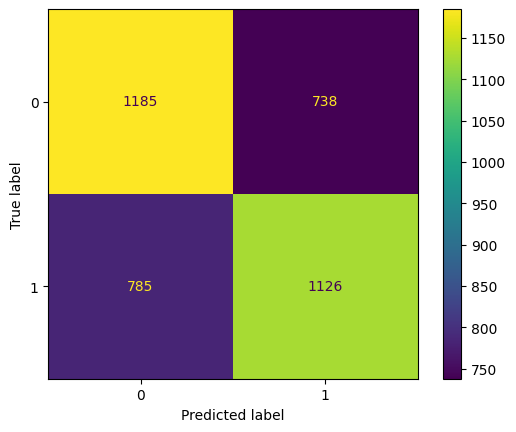

In [12]:
import hs_adda
import hidden_trainer
source_dic  = aug_multi_Hidden_dataset([ghosh, ptacek], None, source_name, device,  layer = 3, max_len = 30, ratio = 0.7)
target_dic  = aug_multi_Hidden_dataset([semeval, isarcasm], [semeval, isarcasm], target_name, device,  layer = 1, max_len = 30, ratio = 1)

source = 'ghosh'
target = 'semeval'
tgt_val = target_dic[target + '_val']
print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_all/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_all/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
y_pred, y_true = trainer_two.predict()
report = classification_report(y_true, y_pred, output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))
cfm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['0', '1'])
cm_display.plot()

================== Source:  ghosh || Target:  isarcasm ==================
Class 1: F1:0.3243, Recall0.3355, Precision0.3138
Macro avg: F1:0.5869, Recall0.5894, Precision0.5848


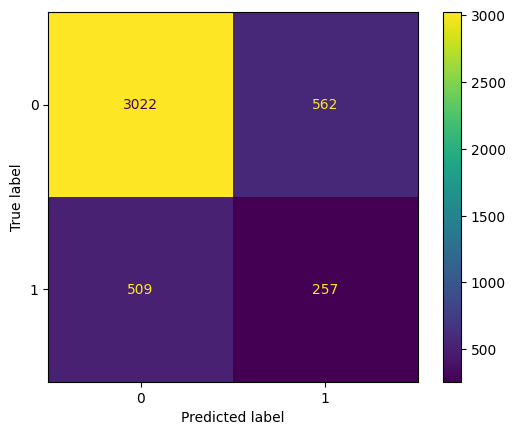

In [13]:
import hs_adda
import hidden_trainer


source = 'ghosh'
target = 'isarcasm'
tgt_val = target_dic[target + '_val']
print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_all/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_all/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
y_pred, y_true = trainer_two.predict()
report = classification_report(y_true, y_pred, output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))
cfm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['0', '1'])
cm_display.plot()

================== Source:  ptacek || Target:  semeval ==================
Class 1: F1:0.6334, Recall0.5777, Precision0.7010
Macro avg: F1:0.6639, Recall0.6664, Precision0.6719


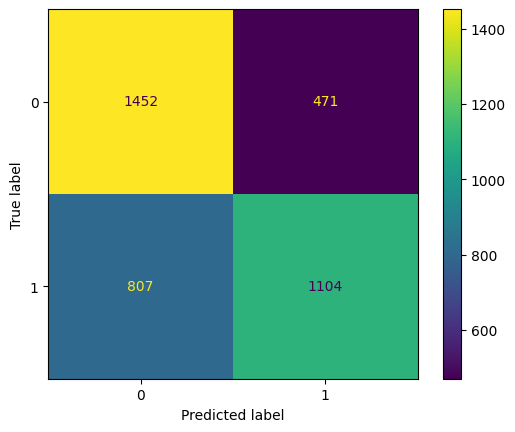

In [14]:
import hs_adda
import hidden_trainer


source = 'ptacek'
target = 'semeval'
tgt_val = target_dic[target + '_val']
print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_all/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_all/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
y_pred, y_true = trainer_two.predict()
report = classification_report(y_true, y_pred, output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))
cfm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['0', '1'])
cm_display.plot()

================== Source:  ptacek || Target:  isarcasm ==================
Class 1: F1:0.3183, Recall0.3460, Precision0.2948
Macro avg: F1:0.5785, Recall0.5845, Precision0.5748


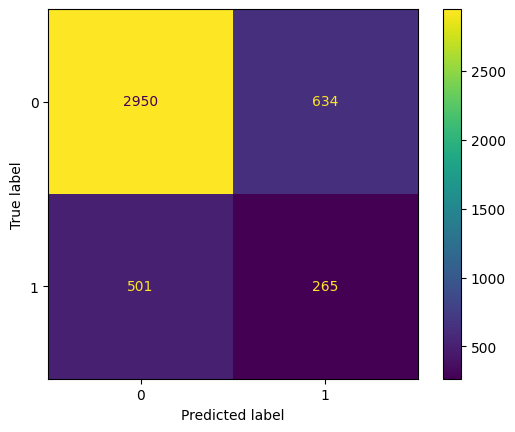

In [15]:
import hs_adda
import hidden_trainer


source = 'ptacek'
target = 'isarcasm'
tgt_val = target_dic[target + '_val']
print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'1_all/'+source+'_'+target+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + '1_all/'+source+'_'+target+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, tgt_val, tgt_val, tgt_val, tgt_val, device, source + '_' + target)
y_pred, y_true = trainer_two.predict()
report = classification_report(y_true, y_pred, output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))
cfm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['0', '1'])
cm_display.plot()

================== Source:  ptacek || Target:  politcal ==================
Class 1: F1:0.6468, Recall0.7160, Precision0.5898
Macro avg: F1:0.6045, Recall0.6090, Precision0.6143


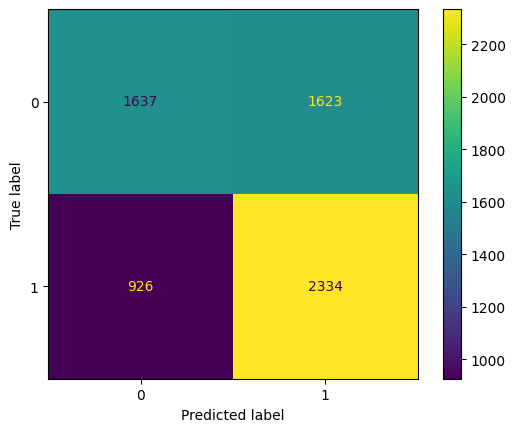

In [16]:
source = 'ptacek'
target = 'politcal'

tokenizer_data = BertTokenizer.from_pretrained('bert-base-uncased')
config_data = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
model_data = BertModel.from_pretrained('bert-base-uncased', config = config_data)
model_data = model_data.to(device)

source_name = ['ghosh', 'ptacek']
target_name = ['political']
political_hidden = HiddenStateDataset(political, model_data, tokenizer_data, device, 1, max_len = 30)

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'political/'+source+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + 'political/'+source+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, political_hidden, political_hidden, political_hidden, political_hidden, device, source + '_' + target)
y_pred, y_true = trainer_two.predict()
report = classification_report(y_true, y_pred, output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))
cfm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['0', '1'])
cm_display.plot()

================== Source:  ghosh || Target:  politcal ==================
Class 1: F1:0.6120, Recall0.6945, Precision0.5470
Macro avg: F1:0.5515, Recall0.5597, Precision0.5643


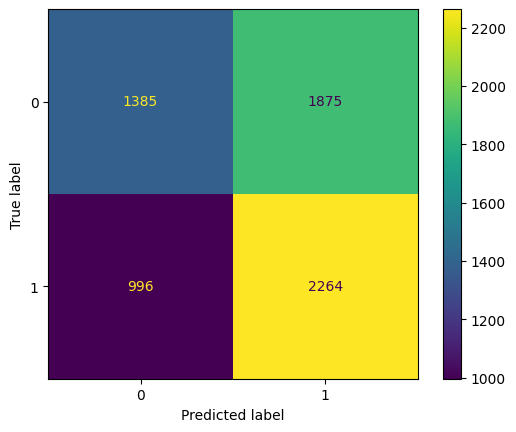

In [17]:
source = 'ghosh'
target = 'politcal'

print('================== Source: ', source, '|| Target: ', target,'==================')
tgt_encoder = hs_adda.HS_ADDN_Encoder_1()
discriminator = hs_adda.HS_ADDN_Discriminator_0()
src_classifier = hs_adda.HS_ADDN_Classifier_1()
trained_classifier = model_path+'political/'+source+'/classifier.pt'
src_classifier.load_state_dict(torch.load(trained_classifier, map_location=torch.device('cpu')))
trained_encoder = model_path + 'political/'+source+'/target_encoder.pt'
tgt_encoder.load_state_dict(torch.load(trained_encoder, map_location=torch.device('cpu')))
trainer_two = hidden_trainer.Hidden_Trainer_One(cfg_1, tgt_encoder, src_classifier, discriminator, political_hidden, political_hidden, political_hidden, political_hidden, device, source + '_' + target)
y_pred, y_true = trainer_two.predict()
report = classification_report(y_true, y_pred, output_dict=True)
print('Class 1: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['1.0']['f1-score'], report['1.0']['recall'], report['1.0']['precision']))
print('Macro avg: F1:{:.4f}, Recall{:.4f}, Precision{:.4f}'.format(report['macro avg']['f1-score'], report['macro avg']['recall'], report['macro avg']['precision']))
cfm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['0', '1'])
cm_display.plot()